In [1]:
#-------------------------------------------------------------------------------------------
#Latent-space face impersonation experiments for MSc research.
#
#This notebook is for controlled experiments on public datasets and synthetic outputs.
#Do not apply to real people or real systems.
#The goal is to evaluate robustness and mitigation strategies for biometric verification.
#
#Author: Stella Williams
#-------------------------------------------------------------------------------------------



'\nLatent-space face impersonation experiments for MSc research.\n\nThis notebook is for controlled experiments on public datasets and synthetic outputs.\nDo not apply to real people or real systems.\nThe goal is to evaluate robustness and mitigation strategies for biometric verification.\n\nAuthor: Stella Williams\n'

In [2]:
#Cell 1: Install and imports"
#-------------------------------------------------------------------------------------------
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from facenet_pytorch import InceptionResnetV1


In [3]:
#Cell 2: Device, FaceNet model, helpers"
#-------------------------------------------------------------------------------------------

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pretrained FaceNet embeddings
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

# Preprocessing for FaceNet (160x160)
to_facenet = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return img

def img_to_tensor(img):
    t = to_facenet(img).unsqueeze(0).to(device)
    return t

@torch.no_grad()
def facenet_embed(img_tensor):
    # img_tensor: [1,3,160,160]
    emb = facenet(img_tensor)
    emb = nn.functional.normalize(emb, p=2, dim=1)
    return emb

def cosine(a, b):
    return (a * b).sum(dim=1)


Using device: cpu


In [4]:
# Images in dataset
#-------------------------------------------------------------------------------------------
SOURCE_IMG_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw-dataset/Jim_Beattie/Jim_Beattie_0001.jpg"
TARGET_A_PATH   = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean//Datasets/lfw-dataset/Lenny_Kravitz/Lenny_Kravitz_0001.jpg"
TARGET_B_PATH   = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean//Datasets/lfw-dataset/Patricia_Clarkson/Patricia_Clarkson_0001.jpg"

source_img = load_image(SOURCE_IMG_PATH)
targetA_img = load_image(TARGET_A_PATH)
targetB_img = load_image(TARGET_B_PATH)

source_t = img_to_tensor(source_img)
targetA_t = img_to_tensor(targetA_img)
targetB_t = img_to_tensor(targetB_img)

with torch.no_grad():
    e_source = facenet_embed(source_t)
    e_A = facenet_embed(targetA_t)
    e_B = facenet_embed(targetB_t)

print("cos(source, targetA):", cosine(e_source, e_A).item())
print("cos(source, targetB):", cosine(e_source, e_B).item())


cos(source, targetA): -0.03934367746114731
cos(source, targetB): -0.09673169255256653


In [5]:
#Cell 4: Load StyleGAN2 (PyTorch)
#-------------------------------------------------------------------------------------------

import sys
sys.path.append("/Users/stel/Documents/Dissertation/msc-biometric-security-clean/stylegan2-ada-pytorch")

import pickle

STYLEGAN_PKL = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/models/stylegan2-ffhq.pkl"

with open(STYLEGAN_PKL, "rb") as f:
    G = pickle.load(f)["G_ema"].to(device).eval()

print("Loaded StyleGAN2 generator")


Loaded StyleGAN2 generator


In [6]:
#Cell 5: Generator helpers (produce images, map to FaceNet space) - StyleGAN output is typically 1024x1024 in [-1, 1]."
#Needs to be converted to FaceNet input."
#-------------------------------------------------------------------------------------------
def synth_from_w(w, noise_mode="const"):
    # w: [1, num_ws, w_dim] for stylegan2-ada
    img = G.synthesis(w, noise_mode=noise_mode)  # [1,3,H,W], range [-1,1]
    img = (img + 1) / 2                          # [0,1]
    img = img.clamp(0, 1)
    return img

def to_facenet_tensor_from_g(img_g):
    # img_g: [1,3,H,W] in [0,1]
    img = nn.functional.interpolate(img_g, size=(160,160), mode="bilinear", align_corners=False)
    return img

@torch.no_grad()
def embed_from_w(w):
    img_g = synth_from_w(w)
    img_f = to_facenet_tensor_from_g(img_g)
    emb = facenet(img_f)
    emb = nn.functional.normalize(emb, p=2, dim=1)
    return emb, img_g


In [7]:
#Cell 6: Step 1, inversion (find a latent for the source)"

#I need a latent representation that reconstructs the source face. 
#Full inversion is a research area, but I will do optimisation-based inversion.

#This is slow on CPU.
#-------------------------------------------------------------------------------------------

# StyleGAN2-ada uses a mapping network: z -> w
# optimise w directly for simplicity: one w per layer (w+)
num_ws = G.synthesis.num_ws
w_dim = G.mapping.w_dim

# Initialise w from random z
z = torch.randn([1, G.z_dim], device=device)
with torch.no_grad():
    w = G.mapping(z, None).detach().clone()

w.requires_grad_(True)


# Losses
mse = nn.MSELoss()

# Simple reconstruction target: downsample source to generator resolution
# match at 160x160 to keep it feasible
source_160 = source_t  # already [1,3,160,160]

opt = optim.Adam([w], lr=0.05)

steps = 300
pbar = tqdm(range(steps), desc="Inversion (source)")

for i in pbar:
    img_g = synth_from_w(w)
    img_f = to_facenet_tensor_from_g(img_g)  # [1,3,160,160]
    
    # Reconstruction loss in pixel space at 160x160
    loss_rec = mse(img_f, source_160)

    opt.zero_grad()
    loss_rec.backward()
    opt.step()

    if (i+1) % 25 == 0:
        pbar.set_postfix({"rec_loss": float(loss_rec.item())})

w_source = w.detach().clone()


Inversion (source): 100%|█| 300/300 [35:23:22<00:00, 424.68s/it, rec_loss=0.0065


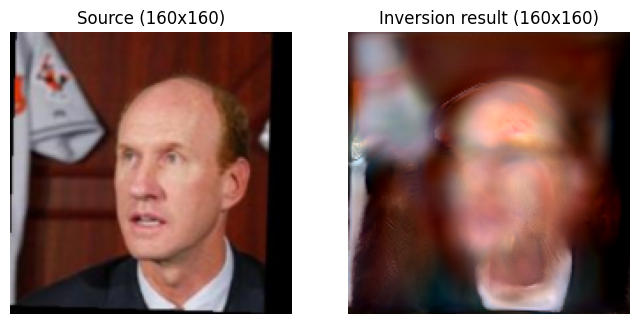

In [8]:
#sanity check
#-------------------------------------------------------------------------------------------
with torch.no_grad():
    img_g = synth_from_w(w_source)
    img_f = to_facenet_tensor_from_g(img_g)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(source_160.squeeze().permute(1,2,0).cpu())
plt.title("Source (160x160)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_f.squeeze().permute(1,2,0).cpu())
plt.title("Inversion result (160x160)")
plt.axis("off")
plt.show()



In [9]:
#Cell 7: Step 2, targeted latent impersonation (source -> targetA)"
#
#Now I optimise in latent space so the generated image embedding moves
#towards the target embedding, while keeping the face visually close to the source inversion.
#
#This is the key experiment.
#-------------------------------------------------------------------------------------------

# Targets
e_target = e_A.detach()

w_adv = w_source.clone().detach()
w_adv.requires_grad = True

opt = optim.Adam([w_adv], lr=0.02)

lambda_id = 1.0     # push towards target identity embedding
lambda_rec = 0.3    # keep close to source image (prevents obvious drift)
steps = 200

pbar = tqdm(range(steps), desc="Latent impersonation (to Target A)")

for i in pbar:
    img_g = synth_from_w(w_adv)
    img_f = to_facenet_tensor_from_g(img_g)

    emb_adv = facenet(img_f)
    emb_adv = nn.functional.normalize(emb_adv, p=2, dim=1)

    # Identity objective: maximise cosine similarity to target
    loss_id = 1 - cosine(emb_adv, e_target).mean()

    # Reconstruction anchor: keep the generated image close to the original inversion
    with torch.no_grad():
        img_g_src = synth_from_w(w_source)
        img_f_src = to_facenet_tensor_from_g(img_g_src)
    loss_rec = mse(img_f, img_f_src)

    loss = lambda_id * loss_id + lambda_rec * loss_rec

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 20 == 0:
        with torch.no_grad():
            cs = cosine(emb_adv, e_target).item()
        pbar.set_postfix({"loss": float(loss.item()), "cos_to_target": float(cs)})

w_targetA = w_adv.detach().clone()


Latent impersonation (to Target A): 100%|█| 200/200 [43:05:41<00:00, 775.71s/it,


Cos(source_w, targetA_img): 0.26349014043807983
Cos(adversarial_w, targetA_img): 0.9808584451675415
Cos(source_w, adversarial_w): 0.32019147276878357


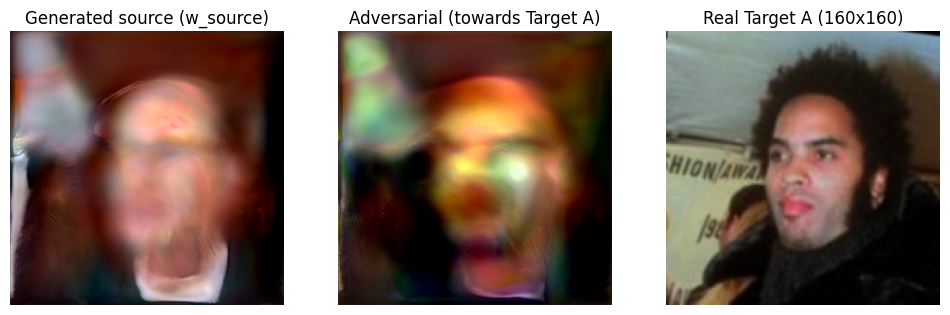

In [10]:
#Cell 8: Evaluate results (source vs targetA)
#-------------------------------------------------------------------------------------------

with torch.no_grad():
    emb_src, img_src = embed_from_w(w_source)
    emb_adv, img_adv = embed_from_w(w_targetA)

print("Cos(source_w, targetA_img):", cosine(emb_src, e_A).item())
print("Cos(adversarial_w, targetA_img):", cosine(emb_adv, e_A).item())
print("Cos(source_w, adversarial_w):", cosine(emb_src, emb_adv).item())

# Show images (generator resolution)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_src.squeeze().permute(1,2,0).cpu())
plt.title("Generated source (w_source)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_adv.squeeze().permute(1,2,0).cpu())
plt.title("Adversarial (towards Target A)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(targetA_t.squeeze().permute(1,2,0).cpu())
plt.title("Real Target A (160x160)")
plt.axis("off")
plt.show()
